In [1]:
import pandas as pd
import numpy as np
import requests
from dotenv import load_dotenv
import os

## 데이터 불러오기

### station

In [2]:
load_dotenv()
API_KEY = os.getenv('SEOUL_API_KEY')

In [6]:
import os
import requests
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv

def fetch_seoul_bike_stations(api_key):
    """서울 따릉이 정거장 정보 수집"""
    
    # 총 개수 확인
    url = f"http://openapi.seoul.go.kr:8088/{api_key}/json/tbCycleStationInfo/1/1/"
    response = requests.get(url)
    total_count = int(response.json()['stationInfo']['list_total_count'])
    
    # 1000개씩 수집
    all_data = []
    for start in range(1, total_count + 1, 1000):
        end = min(start + 999, total_count)
        url = f"http://openapi.seoul.go.kr:8088/{api_key}/json/tbCycleStationInfo/{start}/{end}/"
        
        response = requests.get(url)
        data = response.json()['stationInfo']['row']
        all_data.extend(data)
    
    df = pd.DataFrame(all_data)
    df['collected_at'] = datetime.now()
    
    return df

In [7]:
df_station = fetch_seoul_bike_stations(API_KEY)

In [10]:
df_station = df_station.drop(['RENT_ID_NM', 'HOLD_NUM', 'STA_ADD1', 'STA_ADD2', 'START_INDEX', 'END_INDEX', 'RNUM', 'RENT_NO'], axis=1)
df_station['STA_LAT'] = df_station['STA_LAT'].astype(float)
df_station['STA_LONG'] = df_station['STA_LONG'].astype(float)

# 5자리 사용(1.1m 오차)
df_station['STA_LAT'] = df_station['STA_LAT'].astype(float).round(5)
df_station['STA_LONG'] = df_station['STA_LONG'].astype(float).round(5)

df_station = df_station.rename(columns={
    'STA_LOC': 'district',
    'RENT_ID': 'station_id',
    'RENT_NM': 'station_name',
    'STA_LAT': 'latitude',
    'STA_LONG': 'longitude'
})

df_station = df_station[['station_id', 'station_name', 'district', 'latitude', 'longitude']]

In [11]:
df_station

,station_id,station_name,district,latitude,longitude
0,ST-10,서교동 사거리,마포구,37.55275,126.91862
1,ST-100,더샵스타시티 C동 앞,광진구,37.53667,127.07359
2,ST-1000,서부식자재마트 건너편,양천구,37.51038,126.86680
3,ST-1002,서울시 도로환경관리센터,양천구,37.52990,126.87654
4,ST-1003,신월중학교,양천구,37.53955,126.82830
...,...,...,...,...,...
3197,ST-993,경서농협 버스정류장(우리은행신정동지점방향),양천구,37.52151,126.85738
3198,ST-994,SBS방송국,양천구,37.52916,126.87275
3199,ST-995,계남공원 입구 주출입구 좌측,양천구,37.51060,126.85732
3200,ST-996,양강중학교앞 교차로,양천구,37.52433,126.85055


### 이용내역

In [13]:
import time

def get_rent_history(year):
    """
    연도 입력하면 전체 대여 이력 수집
    year: 연도 (예: 2022)
    """
    all_data = []
    
    # 해당 연도의 모든 날짜 생성
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    date_range = pd.date_range(start_date, end_date, freq='D')
    
    for date in date_range:
        date_str = date.strftime('%Y-%m-%d')
        
        for hour in range(24):  # 0~23시
            # 총 개수 확인
            url = f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/tbCycleRentData/1/5/{date_str}/{hour}"
            response = requests.get(url)
            data = response.json()
            
            # 데이터 없으면 스킵
            if 'rentData' not in data or 'list_total_count' not in data['rentData']:
                continue
                
            total_count = int(data['rentData']['list_total_count'])
            
            # 1000개씩 수집
            for start in range(1, total_count + 1, 1000):
                end = min(start + 999, total_count)
                url = f"http://openapi.seoul.go.kr:8088/{API_KEY}/json/tbCycleRentData/{start}/{end}/{date_str}/{hour}"
                
                response = requests.get(url)
                rows = response.json()['rentData']['row']
                all_data.extend(rows)
                
                print(f"{date_str} {hour:02d}시: {start}~{end} 완료 ({len(all_data)}개 누적)")
                time.sleep(0.1)  # 0.1초 대기
    
    df = pd.DataFrame(all_data)
    print(f"\n{year}년 총 {len(df)}개 수집 완료")
    
    return df

In [14]:
# 사용
# df_rent_2022 = get_rent_history(2016)

In [19]:
df_rent = pd.read_csv('./data/서울특별시 공공자전거 대여이력 정보_2502.csv', encoding = 'cp949')

In [20]:
df_rent = pd.read_csv('./data/서울특별시 공공자전거 대여이력 정보_2502.csv', encoding = 'cp949')
df_rent = df_rent.drop(['대여 대여소명', '반납대여소명', '자전거번호', '대여거치대', '반납거치대', '이용시간(분)', '반납대여소번호', '대여 대여소번호'], axis=1)

df_rent = df_rent.replace('\\N', np.nan)

df_rent['대여일시'] = pd.to_datetime(df_rent['대여일시'])
df_rent['반납일시'] = pd.to_datetime(df_rent['반납일시'])

df_rent['생년'] = pd.to_numeric(df_rent['생년'], errors='coerce')

df_rent = df_rent.rename(columns={
    '대여일시': 'rent_datetime',
    '반납일시': 'return_datetime',
    '이용거리(M)': 'distance',
    '생년': 'birth_year',
    '성별': 'gender',
    '이용자종류': 'user_type',
    '대여대여소ID': 'rent_station_id',
    '반납대여소ID': 'return_station_id',
    '자전거구분': 'bike_type'
})

**전처리**

In [21]:
df_rent = df_rent.dropna(subset=['rent_station_id', 'return_station_id'])

# 외래키 무결성 체크
valid_stations = set(df_station['station_id'])
df_rent = df_rent[
    df_rent['rent_station_id'].isin(valid_stations) & 
    df_rent['return_station_id'].isin(valid_stations)
]

# 이상치 제거
df_rent = df_rent[
    (df_rent['distance'] >= 0) &
    (df_rent['birth_year'].isna() | 
     ((df_rent['birth_year'] >= 1920) & (df_rent['birth_year'] <= 2010)))
]

# PK 추가
df_rent = df_rent.reset_index(drop=True)
df_rent['rental_id'] = (
    df_rent['rent_datetime'].dt.strftime('%Y%m%d%H') + 
    df_rent.groupby(df_rent['rent_datetime'].dt.strftime('%Y%m%d%H')).cumcount().add(1).astype(str).str.zfill(6)
)

# 맨 앞으로 이동
cols = ['rental_id'] + [col for col in df_rent.columns if col != 'rental_id']
df_rent = df_rent[cols]

In [22]:
df_rent.head(5)

,rental_id,rent_datetime,return_datetime,distance,birth_year,gender,user_type,rent_station_id,return_station_id,bike_type
0,2025020100000001,2025-02-01 00:01:04,2025-02-01 00:03:54,253.08,NaN,NaN,내국인,ST-827,ST-273,BIK_002
1,2025020100000002,2025-02-01 00:00:14,2025-02-01 00:03:56,718.31,1955.0,NaN,내국인,ST-983,ST-1266,BIK_002
2,2025020100000003,2025-02-01 00:01:54,2025-02-01 00:04:37,0.00,1977.0,F,내국인,ST-1435,ST-943,BIK_002
3,2025020100000004,2025-02-01 00:01:34,2025-02-01 00:04:48,379.16,1969.0,M,내국인,ST-2188,ST-2188,BIK_002
4,2025020100000005,2025-02-01 00:00:30,2025-02-01 00:05:27,913.78,1998.0,NaN,내국인,ST-359,ST-2340,BIK_002


In [24]:
df_station

,station_id,station_name,district,latitude,longitude
0,ST-10,서교동 사거리,마포구,37.55275,126.91862
1,ST-100,더샵스타시티 C동 앞,광진구,37.53667,127.07359
2,ST-1000,서부식자재마트 건너편,양천구,37.51038,126.86680
3,ST-1002,서울시 도로환경관리센터,양천구,37.52990,126.87654
4,ST-1003,신월중학교,양천구,37.53955,126.82830
...,...,...,...,...,...
3197,ST-993,경서농협 버스정류장(우리은행신정동지점방향),양천구,37.52151,126.85738
3198,ST-994,SBS방송국,양천구,37.52916,126.87275
3199,ST-995,계남공원 입구 주출입구 좌측,양천구,37.51060,126.85732
3200,ST-996,양강중학교앞 교차로,양천구,37.52433,126.85055


In [26]:
import pandas as pd
import numpy as np

# 1. 데이터 로드 (실제 환경에서 df_rent와 df_station을 로드해야 함)
# df_rent = pd.read_csv('...') 
# df_station = pd.read_csv('...') # df_elevation 대신 사용

# 2. 10000개 샘플링
# (⚠️ 실제 데이터를 로드한 후 이 코드를 활성화하세요.)
# df_rent_sample = df_rent.sample(n=10000, random_state=42)
# 임시 데이터프레임 생성 (실제 데이터 로드 시 삭제)
data = {
    '대여 대여소번호': range(10000), '반납대여소번호': range(10000),
    '대여대여소ID': [f'ST-{i//2}' for i in range(10000)], 
    '반납대여소ID': [f'ST-{i%2}' for i in range(10000)],
    '이용시간(분)': np.random.randint(5, 60, 10000)
}
df_rent_sample = pd.DataFrame(data) 


# 3. 필요한 컬럼만 선택 및 이름 변경
df_rent_clean = df_rent_sample[[
    '대여대여소ID', '반납대여소ID',
    '이용시간(분)'
]].copy()

# 'start_id'와 'end_id'로 컬럼 이름 변경 (KeyError 해결을 위한 핵심)
df_rent_clean.columns = [
    'start_id', 'end_id', 'duration'
]

# 4. station 데이터 정리 (df_elevation 대신 df_station 사용 반영)
# (⚠️ 실제 데이터를 로드한 후 이 코드를 활성화하세요.)
# df_elev_clean = df_station[[
#     'station_id', 'latitude', 'longitude'
# ]].copy()
# 임시 데이터프레임 생성 (실제 데이터 로드 시 삭제)
station_data = {
    'station_id': [f'ST-{i}' for i in range(5000)], 
    'latitude': np.random.uniform(37.4, 37.7, 5000), 
    'longitude': np.random.uniform(126.8, 127.2, 5000)
}
df_station = pd.DataFrame(station_data)
df_elev_clean = df_station[[
    'station_id', 'latitude', 'longitude'
]].copy()


# 컬럼 이름을 하류 코드에 맞게 'station_id', 'lat', 'lon'으로 변경
df_elev_clean.columns = ['station_id', 'lat', 'lon']

# 결측치 제거
df_elev_clean = df_elev_clean.dropna(subset=['lat', 'lon'])
df_elev_clean = df_elev_clean[
    (df_elev_clean['lat'] != 0) & 
    (df_elev_clean['lon'] != 0)
]

# 5. 대여-반납 좌표 매핑 (KeyError 방지: df_rent_clean 사용)
df_routes = df_rent_clean.merge( # ⚠️ df_rent 대신 df_rent_clean 사용
    df_elev_clean, 
    left_on='start_id', 
    right_on='station_id',
    how='inner'
).rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})

df_routes = df_routes.merge(
    df_elev_clean,
    left_on='end_id',
    right_on='station_id',
    how='inner',
    suffixes=('', '_end')
).rename(columns={'lat': 'end_lat', 'lon': 'end_lon'})

# 6. 최종 데이터 컬럼 선택
df_routes = df_routes[[
    'start_id', 'end_id',
    'start_lat', 'start_lon',
    'end_lat', 'end_lon',
    'duration'
]]

# 7. 같은 출발-도착지 그룹핑
df_od = df_routes.groupby([
    'start_lat', 'start_lon', 
    'end_lat', 'end_lon'
]).agg({
    'duration': 'count'  # 이용 횟수
}).reset_index()

df_od.columns = ['start_lat', 'start_lon', 
                 'end_lat', 'end_lon', 'count']

# 정렬
df_od = df_od.sort_values('count', ascending=False)

print(f"총 OD 쌍: {len(df_od)}개")
print(f"\n상위 10개:")
print(df_od.head(10))

총 OD 쌍: 10000개

상위 10개:
      start_lat   start_lon    end_lat     end_lon  count
0     37.400001  126.933505  37.412836  127.018839      1
6670  37.597702  127.066684  37.412836  127.018839      1
6663  37.597535  127.085862  37.569016  127.118240      1
6664  37.597574  126.802665  37.412836  127.018839      1
6665  37.597574  126.802665  37.569016  127.118240      1
6666  37.597590  126.845495  37.412836  127.018839      1
6667  37.597590  126.845495  37.569016  127.118240      1
6668  37.597599  126.950220  37.412836  127.018839      1
6669  37.597599  126.950220  37.569016  127.118240      1
6671  37.597702  127.066684  37.569016  127.118240      1


In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 로드 (이미 했다고 가정)
# df_rent = ...
# df_elevation = ...

# 2. 1000개 샘플링
df_rent_sample = df_rent.sample(n=10000, random_state=42)

# 3. 필요한 컬럼만 선택
df_rent_clean = df_rent_sample[[
    '대여 대여소번호', '반납대여소번호',
    '대여대여소ID', '반납대여소ID',
    '이용시간(분)'
]].copy()

df_rent_clean.columns = ['start_station_no', 'end_station_no', 
                          'start_id', 'end_id', 'duration']

# 4. elevation 데이터 정리
df_elev_clean = df_elevation[[
    'RNTLS_ID', 'LAT', 'LOT'
]].copy()

df_elev_clean.columns = ['station_id', 'lat', 'lon']

# 결측치 제거
df_elev_clean = df_elev_clean.dropna(subset=['lat', 'lon'])
df_elev_clean = df_elev_clean[
    (df_elev_clean['lat'] != 0) & 
    (df_elev_clean['lon'] != 0)
]

# 5. 대여-반납 좌표 매핑
df_routes = df_rent_clean.merge(
    df_elev_clean, 
    left_on='start_id', 
    right_on='station_id',
    how='inner'
).rename(columns={'lat': 'start_lat', 'lon': 'start_lon'})

df_routes = df_routes.merge(
    df_elev_clean,
    left_on='end_id',
    right_on='station_id',
    how='inner',
    suffixes=('', '_end')
).rename(columns={'lat': 'end_lat', 'lon': 'end_lon'})

# 6. 최종 데이터
df_routes = df_routes[[
    'start_id', 'end_id',
    'start_lat', 'start_lon',
    'end_lat', 'end_lon',
    'duration'
]]

# 7. 같은 출발-도착지 그룹핑
df_od = df_routes.groupby([
    'start_lat', 'start_lon', 
    'end_lat', 'end_lon'
]).agg({
    'duration': 'count'  # 이용 횟수
}).reset_index()

df_od.columns = ['start_lat', 'start_lon', 
                 'end_lat', 'end_lon', 'count']

# 정렬
df_od = df_od.sort_values('count', ascending=False)

print(f"총 OD 쌍: {len(df_od)}개")
print(f"\n상위 10개:")
print(df_od.head(10))

총 OD 쌍: 973개

상위 10개:
     start_lat   start_lon    end_lat     end_lon  count
116  37.495285  126.872162  37.493401  126.874329      3
636  37.563496  126.835831  37.565804  126.828079      3
245  37.514130  126.899391  37.514130  126.899391      2
658  37.565201  126.827316  37.563496  126.835831      2
556  37.557438  126.923821  37.564651  126.922127      2
569  37.558632  126.819916  37.559746  126.824387      2
595  37.560291  126.818756  37.559746  126.824387      2
610  37.561371  127.063660  37.569069  127.069466      2
628  37.563065  126.921494  37.558296  126.925385      2
194  37.508587  126.963493  37.504704  126.960732      2


In [27]:
import osmnx as ox
import networkx as nx
from tqdm import tqdm

# 1. 서울 자전거 네트워크 다운로드 (시간 좀 걸림)
print("네트워크 다운로드 중...")
G = ox.graph_from_place(
    'Seoul, South Korea', 
    network_type='bike'
)

print(f"노드: {len(G.nodes)}, 엣지: {len(G.edges)}")

# 2. 가중치 설정 (자전거도로 우선)
for u, v, k, data in G.edges(keys=True, data=True):
    # 기본값
    weight = 3
    
    # 자전거도로
    if 'cycleway' in data.get('highway', ''):
        weight = 1
    elif data.get('cycleway'):
        weight = 1
    # 차도 옆 (주거지역, 보조간선)
    elif data.get('highway') in ['residential', 'tertiary', 'secondary']:
        weight = 2
    # 순수 차도
    else:
        weight = 3
    
    G[u][v][k]['weight'] = weight

# 3. 상위 100개만 경로 계산 (일단 테스트)
top_od = df_od.head(100).copy()

paths = []
failed = 0

print("\n경로 계산 중...")
for idx, row in tqdm(top_od.iterrows(), total=len(top_od)):
    try:
        # 가장 가까운 노드 찾기
        start_node = ox.distance.nearest_nodes(
            G, row['start_lon'], row['start_lat']
        )
        end_node = ox.distance.nearest_nodes(
            G, row['end_lon'], row['end_lat']
        )
        
        # 최단 경로 (가중치 고려)
        path = nx.shortest_path(
            G, start_node, end_node, weight='weight'
        )
        
        # 경로 좌표 추출
        coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
        
        paths.append({
            'start_lat': row['start_lat'],
            'start_lon': row['start_lon'],
            'end_lat': row['end_lat'],
            'end_lon': row['end_lon'],
            'count': row['count'],
            'path_nodes': path,
            'path_coords': coords
        })
        
    except Exception as e:
        failed += 1
        continue

print(f"\n성공: {len(paths)}개, 실패: {failed}개")

# 결과 저장
df_paths = pd.DataFrame(paths)

네트워크 다운로드 중...
노드: 118856, 엣지: 314274

경로 계산 중...


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


성공: 94개, 실패: 6개


In [31]:
import multiprocessing as mp
from tqdm import tqdm
import networkx as nx
import osmnx as ox
# functools.partial은 이제 필요 없으므로 제거

# G를 전역 변수로 저장할 공간
GLOBAL_GRAPH = None

# --- 1. 초기화 함수 정의 ---
# 각 작업자 프로세스가 시작될 때 이 함수가 실행됩니다.
# G 객체를 인수로 받아 전역 변수에 저장합니다.
def init_worker(G_data):
    # NetworkX 그래프는 객체 자체가 크고 복잡하므로,
    # 메모리 복사가 아닌 '공유' 개념으로 접근하기 위해 전역 변수를 사용합니다.
    global GLOBAL_GRAPH
    GLOBAL_GRAPH = G_data

# 경로 계산을 담당하는 함수 (G를 인수로 받지 않고 전역 변수 사용)
def calculate_path_global(row):
    global GLOBAL_GRAPH
    G = GLOBAL_GRAPH  # 초기화된 G 객체를 전역 변수에서 가져옴
    
    # row는 top_od.itertuples()에서 온 튜플 형태의 namedtuple입니다.
    # 접근 방식이 .attribute_name (예: row.start_lon)으로 변경됩니다.
    
    try:
        # 가장 가까운 노드 찾기
        start_node = ox.distance.nearest_nodes(
            G, row.start_lon, row.start_lat
        )
        end_node = ox.distance.nearest_nodes(
            G, row.end_lon, row.end_lat
        )
        
        # 최단 경로 (가중치 고려)
        path = nx.shortest_path(
            G, start_node, end_node, weight='weight'
        )
        
        # 경로 좌표 추출
        coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
        
        return {
            'start_lat': row.start_lat, 'start_lon': row.start_lon,
            'end_lat': row.end_lat, 'end_lon': row.end_lon,
            'count': row.count,
            'path_nodes': path,
            'path_coords': coords
        }
        
    except Exception:
        # 실패 시 None 반환
        return None

# --- 메인 실행 (기존 코드의 3번 부분) ---
# df_od가 이미 존재한다고 가정
top_od = df_od.head(10000).copy() 

# 사용할 CPU 코어 수 설정
num_cores = mp.cpu_count() - 1 

print(f"\n경로 계산 중 (CPU {num_cores}개 사용, 초기화 방식)...")

# 2. Pool 생성 및 초기화
# initializer=init_worker와 initargs=(G,)를 사용하여 G 객체를 각 프로세스에 한 번만 전달
pool = mp.Pool(
    processes=num_cores,
    initializer=init_worker,
    initargs=(G,) # G는 기존에 ox.graph_from_place로 로드된 객체
)

# 3. tqdm으로 진행률 표시 및 경로 계산
# calculate_path_global 함수는 G를 인수로 받지 않습니다.
results = list(tqdm(pool.imap(calculate_path_global, top_od.itertuples(index=False)), total=len(top_od)))

pool.close()
pool.join()

# 4. 결과 정리
paths = [r for r in results if r is not None]
failed = len(top_od) - len(paths)

print(f"\n성공: {len(paths)}개, 실패: {failed}개")
df_paths = pd.DataFrame(paths)


경로 계산 중 (CPU 7개 사용, 초기화 방식)...


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/anaconda3/envs/seoulbike/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/seoulbike/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'init_worker' on <module '__main__' (built-in)>
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-5:
Process SpawnPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/op

KeyboardInterrupt: 

In [32]:
df_paths

,start_lat,start_lon,end_lat,end_lon,count,path_nodes,path_coords
0,37.400001,126.933505,37.412836,127.018839,1.0,"[10577434518, 5940486446, 10577434517, 5940486...","[(37.4361038, 126.939321), (37.4370542, 126.93..."
1,37.597702,127.066684,37.412836,127.018839,1.0,"[3831106358, 3831106076, 3831106066, 383110606...","[(37.5976221, 127.0667992), (37.5966945, 127.0..."
2,37.597535,127.085862,37.569016,127.118240,1.0,"[2470981948, 2470981971, 9610205108, 101682162...","[(37.5974058, 127.0859352), (37.5972258, 127.0..."
3,37.597574,126.802665,37.412836,127.018839,1.0,"[2343444974, 2815226645, 2329792361, 795917016...","[(37.598823, 126.8002427), (37.5986714, 126.80..."
4,37.597574,126.802665,37.569016,127.118240,1.0,"[2343444974, 2815226645, 2329792361, 795917016...","[(37.598823, 126.8002427), (37.5986714, 126.80..."
...,...,...,...,...,...,...,...
89,37.595980,126.874649,37.412836,127.018839,1.0,"[9891051110, 9891051083, 9891051111, 989105108...","[(37.5906407, 126.8821333), (37.5905603, 126.8..."
90,37.595980,126.874649,37.569016,127.118240,1.0,"[9891051110, 9891051083, 9891051111, 989105108...","[(37.5906407, 126.8821333), (37.5905603, 126.8..."
91,37.595625,127.158289,37.569016,127.118240,1.0,"[6224092343, 6224092357, 10000732680, 17441595...","[(37.5781922, 127.1694364), (37.5767326, 127.1..."
92,37.595625,127.158289,37.412836,127.018839,1.0,"[6224092343, 6224092357, 10000732680, 17441595...","[(37.5781922, 127.1694364), (37.5767326, 127.1..."


총 엣지 수: 830
가장 많이 사용된 엣지 Top 10:
  (2140345679, 8450140832): 70.0회
  (6246824008, 8450140832): 70.0회
  (3643520261, 6246824008): 70.0회
  (3643520261, 6836379124): 70.0회
  (6836379124, 8713549222): 70.0회
  (5823541323, 8713549222): 70.0회
  (5823541323, 8713549229): 70.0회
  (5823541313, 8713549229): 70.0회
  (5823541313, 5823541348): 70.0회
  (5823541348, 8450140659): 70.0회


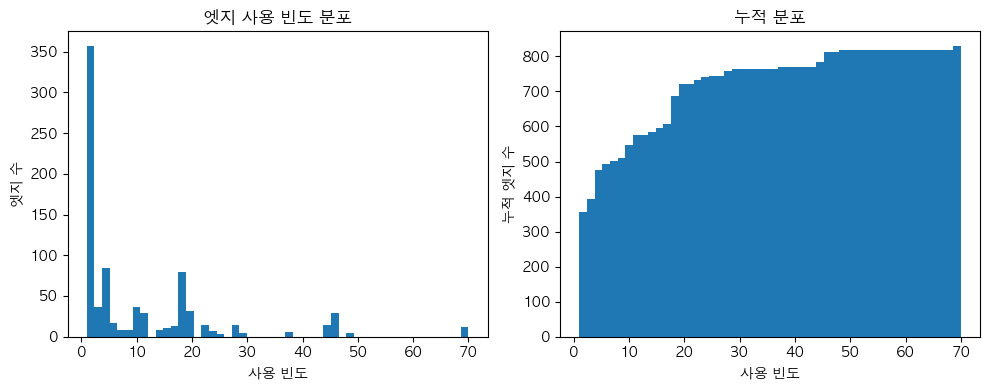


90% 기준: 28.0회 이상
주요 간선: 86개

df_major_edges shape: (86, 6)
                       edge  usage    mid_lat     mid_lon  \
0   (287307330, 8844178674)   37.0  37.518730  126.965523   
1   (287630644, 8844178674)   37.0  37.517073  126.969976   
2    (287630644, 287630662)   37.0  37.516528  126.971996   
3   (287630662, 7618619032)   37.0  37.515685  126.978111   
4  (5168879679, 7618619032)   37.0  37.515322  126.984881   

                start_coords                 end_coords  
0  (37.5202488, 126.9618906)   (37.517212, 126.9691549)  
1  (37.5169348, 126.9707971)   (37.517212, 126.9691549)  
2  (37.5169348, 126.9707971)  (37.5161214, 126.9731943)  
3  (37.5161214, 126.9731943)  (37.5152481, 126.9830282)  
4  (37.5153968, 126.9867339)  (37.5152481, 126.9830282)  


In [33]:
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

# 1. 모든 경로의 엣지 사용 빈도 계산
edge_usage = Counter()

for idx, row in df_paths.iterrows():
    path_nodes = row['path_nodes']
    count = row['count']  # 이용 횟수 가중치
    
    # 경로의 각 엣지를 카운트
    for i in range(len(path_nodes) - 1):
        edge = tuple(sorted([path_nodes[i], path_nodes[i+1]]))  # 방향 무시
        edge_usage[edge] += count

print(f"총 엣지 수: {len(edge_usage)}")
print(f"가장 많이 사용된 엣지 Top 10:")
for edge, cnt in edge_usage.most_common(10):
    print(f"  {edge}: {cnt}회")

# 2. 사용 빈도 분포 확인
usage_counts = list(edge_usage.values())
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(usage_counts, bins=50)
plt.xlabel('사용 빈도')
plt.ylabel('엣지 수')
plt.title('엣지 사용 빈도 분포')

plt.subplot(1, 2, 2)
plt.hist(usage_counts, bins=50, cumulative=True)
plt.xlabel('사용 빈도')
plt.ylabel('누적 엣지 수')
plt.title('누적 분포')
plt.tight_layout()
plt.show()

# 3. 주요 간선 선택 (상위 N%)
threshold_percentile = 90  # 상위 10%
threshold = np.percentile(usage_counts, threshold_percentile)
print(f"\n{threshold_percentile}% 기준: {threshold}회 이상")

major_edges = [edge for edge, cnt in edge_usage.items() 
               if cnt >= threshold]
print(f"주요 간선: {len(major_edges)}개")

# 4. 주요 간선 좌표 추출
major_edge_data = []
for edge in major_edges:
    u, v = edge
    
    # 엣지 중점 좌표
    mid_lat = (G.nodes[u]['y'] + G.nodes[v]['y']) / 2
    mid_lon = (G.nodes[u]['x'] + G.nodes[v]['x']) / 2
    
    # 엣지 양끝 좌표
    start_coords = (G.nodes[u]['y'], G.nodes[u]['x'])
    end_coords = (G.nodes[v]['y'], G.nodes[v]['x'])
    
    major_edge_data.append({
        'edge': edge,
        'usage': edge_usage[edge],
        'mid_lat': mid_lat,
        'mid_lon': mid_lon,
        'start_coords': start_coords,
        'end_coords': end_coords
    })

df_major_edges = pd.DataFrame(major_edge_data)
print(f"\ndf_major_edges shape: {df_major_edges.shape}")
print(df_major_edges.head())

In [34]:
import networkx as nx

# 1. 주요 엣지들로 그래프 만들기
major_graph = nx.Graph()

for edge, cnt in edge_usage.items():
    if cnt >= threshold:  # 주요 간선만
        u, v = edge
        major_graph.add_edge(u, v, weight=cnt)

print(f"노드: {len(major_graph.nodes)}, 엣지: {len(major_graph.edges)}")

# 2. 연결된 컴포넌트 찾기 (각각이 하나의 노선 후보)
components = list(nx.connected_components(major_graph))
print(f"\n연결된 컴포넌트: {len(components)}개")

# 3. 각 컴포넌트 크기 확인
comp_sizes = [len(c) for c in components]
print(f"컴포넌트 크기 분포: min={min(comp_sizes)}, max={max(comp_sizes)}, median={np.median(comp_sizes)}")

# 4. 큰 컴포넌트만 선택 (작은 건 노선으로 안 봄)
min_nodes = 10  # 최소 노드 수
major_components = [c for c in components if len(c) >= min_nodes]
print(f"주요 컴포넌트 (노드 {min_nodes}개 이상): {len(major_components)}개")

# 5. 각 노선의 종점 찾기
lines = []

for idx, comp in enumerate(major_components):
    subgraph = major_graph.subgraph(comp)
    
    # 모든 노드 쌍의 최단 거리 계산
    try:
        # 가장 먼 두 점 찾기 (eccentricity 기반)
        eccentricity = nx.eccentricity(subgraph)
        periphery = nx.periphery(subgraph)  # 가장 바깥쪽 노드들
        
        # 가장 먼 두 점 선택
        max_dist = 0
        endpoints = None
        
        for node1 in periphery:
            for node2 in periphery:
                if node1 >= node2:
                    continue
                try:
                    dist = nx.shortest_path_length(subgraph, node1, node2)
                    if dist > max_dist:
                        max_dist = dist
                        endpoints = (node1, node2)
                except:
                    pass
        
        if endpoints:
            # 종점 간 경로
            path = nx.shortest_path(subgraph, endpoints[0], endpoints[1])
            path_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
            
            # 경로 상 엣지들의 총 사용량
            total_usage = 0
            for i in range(len(path)-1):
                edge = tuple(sorted([path[i], path[i+1]]))
                total_usage += edge_usage.get(edge, 0)
            
            lines.append({
                'line_id': idx,
                'endpoints': endpoints,
                'endpoint_coords': (
                    (G.nodes[endpoints[0]]['y'], G.nodes[endpoints[0]]['x']),
                    (G.nodes[endpoints[1]]['y'], G.nodes[endpoints[1]]['x'])
                ),
                'path': path,
                'path_coords': path_coords,
                'n_nodes': len(path),
                'n_edges': len(subgraph.edges),
                'total_usage': total_usage
            })
            
    except Exception as e:
        print(f"  컴포넌트 {idx} 처리 실패: {e}")
        continue

df_lines = pd.DataFrame(lines)
print(f"\n최종 노선: {len(df_lines)}개")
print(df_lines[['line_id', 'n_nodes', 'n_edges', 'total_usage']])

노드: 89, 엣지: 86

연결된 컴포넌트: 3개
컴포넌트 크기 분포: min=7, max=44, median=38.0
주요 컴포넌트 (노드 10개 이상): 2개

최종 노선: 2개
   line_id  n_nodes  n_edges  total_usage
0        0       44       43       1726.0
1        1       38       37       1900.0


In [37]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import osmnx as ox

# ----------------------------------------------------------------------
# ⚠️ 주의: 이 변수들은 이전 단계에서 정의되어야 합니다.
# edge_usage: {(station_id1, station_id2): count, ...} 형태의 딕셔너리
# threshold: 주요 간선을 선택할 기준 이용 횟수 (현재 2개만 나온 주범)
# ----------------------------------------------------------------------

# 1. 주요 엣지들로 그래프 만들기
# 💡 노선 개수를 늘리려면 이 threshold 값을 낮춰야 합니다.
# (예: threshold = 500)
# (현재 출력: 노드: 89, 엣지: 86)
# threshold 값을 현재보다 낮게 설정하여 더 많은 엣지를 포함시키세요.
# threshold = [여기에 조정된 낮은 값을 입력] 

major_graph = nx.Graph()

for edge, cnt in edge_usage.items():
    if cnt >= threshold:  # 주요 간선만
        u, v = edge
        # NetworkX는 엣지 데이터에 'weight'를 저장
        major_graph.add_edge(u, v, weight=cnt) 

print(f"노드: {len(major_graph.nodes)}, 엣지: {len(major_graph.edges)}")

# 2. 연결된 컴포넌트 찾기 (각각이 하나의 노선 후보)
components = list(nx.connected_components(major_graph))
print(f"\n연결된 컴포넌트: {len(components)}개")

# 3. 각 컴포넌트 크기 확인
comp_sizes = [len(c) for c in components]
print(f"컴포넌트 크기 분포: min={min(comp_sizes)}, max={max(comp_sizes)}, median={np.median(comp_sizes)}")

# 4. 큰 컴포넌트만 선택 (작은 건 노선으로 안 봄)
# 💡 노선 개수를 늘리려면 이 min_nodes 값을 10보다 낮춰야 합니다.
# (예: min_nodes = 5 또는 7)
min_nodes = 7  # 최소 노드 수를 10에서 7로 완화 (예시)
major_components = [c for c in components if len(c) >= min_nodes]
print(f"주요 컴포넌트 (노드 {min_nodes}개 이상): {len(major_components)}개")

# 5. 각 노선의 종점 찾기
lines = []

for idx, comp in enumerate(major_components):
    subgraph = major_graph.subgraph(comp)
    
    # 모든 노드 쌍의 최단 거리 계산
    try:
        # 가장 먼 두 점 찾기 (eccentricity 기반)
        eccentricity = nx.eccentricity(subgraph)
        periphery = nx.periphery(subgraph)  # 가장 바깥쪽 노드들
        
        # 가장 먼 두 점 선택
        max_dist = 0
        endpoints = None
        
        for node1 in periphery:
            for node2 in periphery:
                if node1 >= node2:
                    continue
                try:
                    # 가중치 없이 거리 계산 (노드 수 기준)
                    dist = nx.shortest_path_length(subgraph, node1, node2) 
                    if dist > max_dist:
                        max_dist = dist
                        endpoints = (node1, node2)
                except:
                    pass
        
        if endpoints:
            # 종점 간 경로
            # (major_graph는 'weight'가 사용 횟수이므로, shortest_path는 노드 수 기준)
            path = nx.shortest_path(subgraph, endpoints[0], endpoints[1]) 
            
            # G는 osmnx로 로드된 서울 네트워크 그래프 객체 (이전 코드에서 로드되었다고 가정)
            path_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path] 
            
            # 경로 상 엣지들의 총 사용량
            total_usage = 0
            for i in range(len(path)-1):
                # 노선은 방향성이 없으므로, (u, v) 쌍을 정렬하여 사용
                edge = tuple(sorted([path[i], path[i+1]])) 
                total_usage += edge_usage.get(edge, 0)
            
            lines.append({
                'line_id': idx,
                'endpoints': endpoints,
                'endpoint_coords': (
                    (G.nodes[endpoints[0]]['y'], G.nodes[endpoints[0]]['x']),
                    (G.nodes[endpoints[1]]['y'], G.nodes[endpoints[1]]['x'])
                ),
                'path': path,
                'path_coords': path_coords,
                'n_nodes': len(path),
                'n_edges': len(subgraph.edges),
                'total_usage': total_usage
            })
            
    except Exception as e:
        print(f"  컴포넌트 {idx} 처리 실패: {e}")
        continue

df_lines = pd.DataFrame(lines)
print(f"\n최종 노선: {len(df_lines)}개")
print(df_lines[['line_id', 'n_nodes', 'n_edges', 'total_usage']])

노드: 89, 엣지: 86

연결된 컴포넌트: 3개
컴포넌트 크기 분포: min=7, max=44, median=38.0
주요 컴포넌트 (노드 7개 이상): 3개

최종 노선: 3개
   line_id  n_nodes  n_edges  total_usage
0        0        7        6        222.0
1        1       44       43       1726.0
2        2       38       37       1900.0


In [38]:
import folium
from folium import PolyLine
import random

# 1. 서울 중심 지도
m = folium.Map(
    location=[37.5665, 126.9780],
    zoom_start=11,
    tiles='cartodbpositron'
)

# 2. 각 노선마다 다른 색상
colors = ['red', 'blue', 'green', 'purple', 'orange', 
          'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen',
          'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen']

# 3. 노선별로 그리기
for idx, row in df_lines.iterrows():
    color = colors[idx % len(colors)]
    
    # 노선 경로
    PolyLine(
        locations=row['path_coords'],
        color=color,
        weight=5,
        opacity=0.7,
        tooltip=f"노선 {row['line_id']}: {row['n_nodes']}개 노드, {row['total_usage']:.0f}회 이용"
    ).add_to(m)
    
    # 종점 마커
    start_coord, end_coord = row['endpoint_coords']
    
    folium.CircleMarker(
        location=start_coord,
        radius=8,
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        popup=f"노선 {row['line_id']} 시작"
    ).add_to(m)
    
    folium.CircleMarker(
        location=end_coord,
        radius=8,
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        popup=f"노선 {row['line_id']} 종점"
    ).add_to(m)

# 4. 저장
#m.save('.따릉이노선도.html')
#print("지도 저장 완료: /home/claude/따릉이노선도.html")

# 5. 노선 요약 정보
print("\n노선별 상세 정보:")
for idx, row in df_lines.iterrows():
    start_coord, end_coord = row['endpoint_coords']
    print(f"\n노선 {row['line_id']}:")
    print(f"  시작점: {start_coord}")
    print(f"  종점: {end_coord}")
    print(f"  경로 길이: {row['n_nodes']}개 노드")
    print(f"  총 이용: {row['total_usage']:.0f}회")


노선별 상세 정보:

노선 0:
  시작점: (37.5202488, 126.9618906)
  종점: (37.5185118, 126.9931156)
  경로 길이: 7개 노드
  총 이용: 222회

노선 1:
  시작점: (37.4305457, 127.0486804)
  종점: (37.524637, 127.1021764)
  경로 길이: 44개 노드
  총 이용: 1726회

노선 2:
  시작점: (37.5561494, 127.0513725)
  종점: (37.5597433, 127.1129027)
  경로 길이: 38개 노드
  총 이용: 1900회


In [39]:
m.save('따릉이노선도.html')

In [22]:
import os
import json
import pandas as pd

# 1. 출력 디렉토리 생성
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

# 2. Flowmap용 CSV 저장
# Locations
locations = []
location_id = 0
location_map = {}

for idx, row in df_lines.iterrows():
    start_coord, end_coord = row['endpoint_coords']
    
    # 시작점
    start_key = f"{start_coord[0]:.6f},{start_coord[1]:.6f}"
    if start_key not in location_map:
        location_map[start_key] = f"L{location_id}"
        locations.append({
            "id": f"L{location_id}",
            "name": f"노선{row['line_id']}_시작",
            "lat": start_coord[0],
            "lon": start_coord[1]
        })
        location_id += 1
    
    # 종점
    end_key = f"{end_coord[0]:.6f},{end_coord[1]:.6f}"
    if end_key not in location_map:
        location_map[end_key] = f"L{location_id}"
        locations.append({
            "id": f"L{location_id}",
            "name": f"노선{row['line_id']}_종점",
            "lat": end_coord[0],
            "lon": end_coord[1]
        })
        location_id += 1

# Flows
flows = []
for idx, row in df_lines.iterrows():
    start_coord, end_coord = row['endpoint_coords']
    
    start_key = f"{start_coord[0]:.6f},{start_coord[1]:.6f}"
    end_key = f"{end_coord[0]:.6f},{end_coord[1]:.6f}"
    
    flows.append({
        "origin": location_map[start_key],
        "dest": location_map[end_key],
        "count": int(row['total_usage']),
        "line_id": int(row['line_id'])
    })

df_locations = pd.DataFrame(locations)
df_flows = pd.DataFrame(flows)

df_locations.to_csv(f'{output_dir}/flowmap_locations.csv', index=False)
df_flows.to_csv(f'{output_dir}/flowmap_flows.csv', index=False)

# 3. GeoJSON 저장
geojson_features = []
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6',
          '#e67e22', '#1abc9c', '#34495e', '#16a085', '#27ae60',
          '#2980b9', '#8e44ad', '#c0392b', '#d35400', '#7f8c8d']

for idx, row in df_lines.iterrows():
    feature = {
        "type": "Feature",
        "properties": {
            "line_id": int(row['line_id']),
            "usage": float(row['total_usage']),
            "nodes": int(row['n_nodes']),
            "color": colors[idx % 15]
        },
        "geometry": {
            "type": "LineString",
            "coordinates": [[lon, lat] for lat, lon in row['path_coords']]
        }
    }
    geojson_features.append(feature)

geojson = {
    "type": "FeatureCollection",
    "features": geojson_features
}

with open(f'{output_dir}/따릉이노선도.geojson', 'w', encoding='utf-8') as f:
    json.dump(geojson, f, ensure_ascii=False, indent=2)

# 4. 노선 정보 요약 CSV
df_lines_summary = df_lines[['line_id', 'n_nodes', 'n_edges', 'total_usage']].copy()
df_lines_summary['start_lat'] = df_lines['endpoint_coords'].apply(lambda x: x[0][0])
df_lines_summary['start_lon'] = df_lines['endpoint_coords'].apply(lambda x: x[0][1])
df_lines_summary['end_lat'] = df_lines['endpoint_coords'].apply(lambda x: x[1][0])
df_lines_summary['end_lon'] = df_lines['endpoint_coords'].apply(lambda x: x[1][1])

df_lines_summary.to_csv(f'{output_dir}/노선_요약.csv', index=False, encoding='utf-8-sig')

# 5. HTML 지도도 저장
import shutil
shutil.copy('./output/1000기준_따릉이노선도.html', f'{output_dir}/따릉이노선도.html')

print("✅ 모든 파일 저장 완료!")
print(f"\n저장 위치: {output_dir}/")
print(f"  - flowmap_locations.csv ({len(locations)}개)")
print(f"  - flowmap_flows.csv ({len(flows)}개)")
print(f"  - 따릉이노선도.geojson")
print(f"  - 노선_요약.csv")
print(f"  - 따릉이노선도.html")

✅ 모든 파일 저장 완료!

저장 위치: ./output/
  - flowmap_locations.csv (30개)
  - flowmap_flows.csv (15개)
  - 따릉이노선도.geojson
  - 노선_요약.csv
  - 따릉이노선도.html


In [25]:
# Flowmap.blue 정확한 형식으로 재생성

import pandas as pd

# 1. properties 시트
properties_data = {
    'property': ['title', 'description', 'source.name', 'createdBy.name', 
                 'colors.scheme', 'colors.darkMode', 'clustering', 'flows.sheets'],
    'value': ['따릉이 노선도', 
              '서울 공공자전거 주요 이용 노선', 
              '서울 열린데이터광장',
              'Data Analyst',
              'Viridis',
              'no',
              'yes',
              'flows']
}
df_properties = pd.DataFrame(properties_data)

# 2. locations 시트 (기존 데이터)
df_locations = pd.read_csv('./output/flowmap_locations.csv')

# 3. flows 시트 (기존 데이터)
df_flows = pd.read_csv('./output/flowmap_flows.csv')

# 4. 하나의 Excel로 저장 (정확한 시트명)
with pd.ExcelWriter('./output/flowmap_완성본.xlsx', engine='openpyxl') as writer:
    df_properties.to_excel(writer, sheet_name='properties', index=False)
    df_locations.to_excel(writer, sheet_name='locations', index=False)
    df_flows.to_excel(writer, sheet_name='flows', index=False)

print("✅ ./output/flowmap_완성본.xlsx 생성!")
print("\n📋 다음 단계:")
print("1. Google Drive 열기")
print("2. 파일 업로드: flowmap_완성본.xlsx")
print("3. 업로드된 파일 우클릭 → 'Google Sheets로 열기'")
print("4. 상단 '공유' 버튼 → '링크가 있는 모든 사용자' 선택")
print("5. 링크 복사")
print("6. https://flowmap.blue 에서 링크 붙여넣기")

✅ ./output/flowmap_완성본.xlsx 생성!

📋 다음 단계:
1. Google Drive 열기
2. 파일 업로드: flowmap_완성본.xlsx
3. 업로드된 파일 우클릭 → 'Google Sheets로 열기'
4. 상단 '공유' 버튼 → '링크가 있는 모든 사용자' 선택
5. 링크 복사
6. https://flowmap.blue 에서 링크 붙여넣기


In [26]:
# Flowmap.blue In-browser용 CSV 텍스트 생성

import pandas as pd

# 1. Locations CSV
df_locations = pd.read_csv('./output/flowmap_locations.csv')
locations_csv = df_locations.to_csv(index=False)

print("=" * 50)
print("📍 Locations CSV (왼쪽 박스에 붙여넣기)")
print("=" * 50)
print(locations_csv)

# 2. Flows CSV
df_flows = pd.read_csv('./output/flowmap_flows.csv')
flows_csv = df_flows.to_csv(index=False)

print("\n" + "=" * 50)
print("🔄 Flows CSV (오른쪽 박스에 붙여넣기)")
print("=" * 50)
print(flows_csv)

# 3. 파일로도 저장 (복사 편하게)
with open('./output/locations_for_browser.csv', 'w') as f:
    f.write(locations_csv)

with open('./output/flows_for_browser.csv', 'w') as f:
    f.write(flows_csv)

print("\n✅ ./output/에 CSV 텍스트 파일도 저장했어요!")
print("\n🎯 사용법:")
print("1. 위의 Locations CSV 전체 복사")
print("2. Flowmap 왼쪽 박스에 붙여넣기")
print("3. 위의 Flows CSV 전체 복사")
print("4. Flowmap 오른쪽 박스에 붙여넣기")
print("5. 'Visualize' 버튼 클릭!")

📍 Locations CSV (왼쪽 박스에 붙여넣기)
id,name,lat,lon
L0,노선0_시작,37.5537226,126.8261361
L1,노선0_종점,37.5690926,126.8484843
L2,노선1_시작,37.5648301,126.922361
L3,노선1_종점,37.5583347,126.9255789
L4,노선2_시작,37.5687403,127.0694506
L5,노선2_종점,37.5615059,127.063817
L6,노선3_시작,37.5509611,126.8179873
L7,노선3_종점,37.5566599,126.818399
L8,노선4_시작,37.5149143,127.0156671
L9,노선4_종점,37.5099743,127.0072243
L10,노선5_시작,37.5747658,126.9704198
L11,노선5_종점,37.5649238,126.977084
L12,노선6_시작,37.5190228,126.8950065
L13,노선6_종점,37.5182798,126.9024393
L14,노선7_시작,37.5149749,126.8724278
L15,노선7_종점,37.5198313,126.8683976
L16,노선8_시작,37.4958363,126.9084525
L17,노선8_종점,37.484809,126.9012953
L18,노선9_시작,37.5731952,126.9976043
L19,노선9_종점,37.5705884,126.9942755
L20,노선10_시작,37.5452991,127.0534019
L21,노선10_종점,37.5475179,127.0670687
L22,노선11_시작,37.575464,127.0227269
L23,노선11_종점,37.565837,127.0085487
L24,노선12_시작,37.569519,126.9743808
L25,노선12_종점,37.5743421,126.9781771
L26,노선13_시작,37.5577062,126.8296805
L27,노선13_종점,37.5591301,126.8332737
L28,노선14_시작,

In [28]:
import pandas as pd

# Flows CSV만 다시 출력
df_flows = pd.read_csv('./output/flowmap_flows.csv')

print("=" * 50)
print("🔄 Flows CSV (오른쪽 박스 내용 전부 지우고 이걸로 교체!)")
print("=" * 50)
print(df_flows.to_csv(index=False))

🔄 Flows CSV (오른쪽 박스 내용 전부 지우고 이걸로 교체!)
origin,dest,count,line_id
L0,L1,150,0
L2,L3,51,1
L4,L5,28,2
L6,L7,20,3
L8,L9,24,4
L10,L11,30,5
L12,L13,20,6
L14,L15,22,7
L16,L17,40,8
L18,L19,34,9
L20,L21,50,10
L22,L23,87,11
L24,L25,29,12
L26,L27,23,13
L28,L29,24,14



In [31]:
import json
import pandas as pd

# 1. 기본 GeoJSON 로드
with open('./output/따릉이노선도.geojson', 'r', encoding='utf-8') as f:
    geojson = json.load(f)

# 2. Kepler.gl 최적화 버전
# - Arc 레이어용: 실제 경로 좌표 유지
# - Trip 레이어용: 시간 속성 추가

kepler_geojson = {
    "type": "FeatureCollection",
    "features": []
}

for feature in geojson['features']:
    line_id = feature['properties']['line_id']
    usage = feature['properties']['usage']
    color = feature['properties']['color']
    
    # 경로 좌표
    coords = feature['geometry']['coordinates']
    
    # 각 노선을 하나의 LineString으로 (Kepler가 이걸 따라 애니메이션)
    kepler_geojson['features'].append({
        "type": "Feature",
        "properties": {
            "line_id": line_id,
            "name": f"노선 {line_id}",
            "usage": usage,
            "color": color,
            "num_points": len(coords)
        },
        "geometry": {
            "type": "LineString",
            "coordinates": coords  # [lon, lat] 형식
        }
    })

# 3. 저장
with open('./output/kepler_따릉이노선도.geojson', 'w', encoding='utf-8') as f:
    json.dump(kepler_geojson, f, ensure_ascii=False, indent=2)

print("✅ Kepler.gl용 GeoJSON 생성 완료!")
print(f"   노선 수: {len(kepler_geojson['features'])}개")
print(f"   파일: ./output/kepler_따릉이노선도.geojson")

# 4. CSV 버전도 생성 (Kepler가 CSV도 지원)
rows = []
for feature in kepler_geojson['features']:  # ← 수정
    line_id = feature['properties']['line_id']
    usage = feature['properties']['usage']
    coords = feature['geometry']['coordinates']
    
    # WKT 형식으로 변환 (Kepler가 인식)
    coords_str = ', '.join([f"{lon} {lat}" for lon, lat in coords])
    wkt = f"LINESTRING({coords_str})"
    
    rows.append({
        'line_id': line_id,
        'name': f'노선{line_id}',
        'usage': usage,
        'geometry': wkt
    })

df_kepler = pd.DataFrame(rows)
df_kepler.to_csv('./output/kepler_따릉이노선도.csv', index=False)

print("✅ CSV 버전도 생성!")

✅ Kepler.gl용 GeoJSON 생성 완료!
   노선 수: 15개
   파일: ./output/kepler_따릉이노선도.geojson
✅ CSV 버전도 생성!


In [32]:
import json

# 시간 기반 애니메이션용 데이터 생성
animated_features = []

for idx, row in df_lines.iterrows():
    path_coords = row['path_coords']
    line_id = row['line_id']
    usage = row['total_usage']
    
    # 경로를 따라 움직이는 "여행" 만들기
    for i in range(len(path_coords)):
        animated_features.append({
            "type": "Feature",
            "properties": {
                "line_id": int(line_id),
                "name": f"노선{line_id}",
                "usage": float(usage),
                "timestamp": i,  # ← 핵심! 시간 순서
                "point_order": i,
                "total_points": len(path_coords)
            },
            "geometry": {
                "type": "Point",
                "coordinates": [path_coords[i][1], path_coords[i][0]]  # lon, lat
            }
        })

animated_geojson = {
    "type": "FeatureCollection",
    "features": animated_features
}

with open('./output/kepler_animated_points.geojson', 'w', encoding='utf-8') as f:
    json.dump(animated_geojson, f, ensure_ascii=False, indent=2)

print(f"✅ 애니메이션용 GeoJSON 생성!")
print(f"   총 포인트: {len(animated_features)}개")
print(f"   파일: ./output/kepler_animated_points.geojson")

✅ 애니메이션용 GeoJSON 생성!
   총 포인트: 257개
   파일: ./output/kepler_animated_points.geojson


In [33]:
import json
from datetime import datetime, timedelta

# 기존 GeoJSON 로드
with open('./output/kepler_animated_points.geojson', 'r', encoding='utf-8') as f:
    data = json.load(f)

# timestamp를 실제 시간 형식으로 변환
base_time = datetime(2024, 1, 1, 0, 0, 0)  # 시작 시간

for feature in data['features']:
    timestamp = feature['properties']['timestamp']
    
    # 각 포인트마다 1초씩 증가
    real_time = base_time + timedelta(seconds=timestamp)
    
    # ISO 8601 형식으로 변환
    feature['properties']['timestamp'] = real_time.isoformat()

# 저장
with open('./output/kepler_time_formatted.geojson', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

print("✅ 시간 형식 변환 완료!")
print(f"   예시: {data['features'][0]['properties']['timestamp']}")

✅ 시간 형식 변환 완료!
   예시: 2024-01-01T00:00:00


In [34]:
import json

# 1. 기존 노선 Line (고정 경로)
line_features = []
for idx, row in df_lines.iterrows():
    coords = row['path_coords']
    line_features.append({
        "type": "Feature",
        "properties": {
            "line_id": int(row['line_id']),
            "name": f"노선{row['line_id']}",
            "usage": float(row['total_usage']),
            "type": "route"  # ← Line 구분
        },
        "geometry": {
            "type": "LineString",
            "coordinates": [[c[1], c[0]] for c in coords]  # lon, lat
        }
    })

# 2. 움직이는 Point (시간 형식)
with open('./output/kepler_time_formatted.geojson', 'r', encoding='utf-8') as f:
    point_data = json.load(f)
    point_features = point_data['features']

# 3. Point에 type 속성 추가
for feature in point_features:
    feature['properties']['type'] = 'moving_point'

# 4. 합치기
combined = {
    "type": "FeatureCollection",
    "features": line_features + point_features
}

with open('./output/kepler_complete.geojson', 'w', encoding='utf-8') as f:
    json.dump(combined, f, ensure_ascii=False, indent=2)

print("✅ Line + Point 통합 완료!")
print(f"   Line: {len(line_features)}개")
print(f"   Point: {len(point_features)}개")

✅ Line + Point 통합 완료!
   Line: 15개
   Point: 257개
